In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [2]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf.set_random_seed(1)
sess = tf.InteractiveSession(config=config)

In [3]:
# Load dataset
batch_size = 64
cifar10 = CIFAR10(batch_size=batch_size, validation_proportion=0.1, augment_data=False, file='data_original.csv')

SUMMARIES_DIR = './summaries/convnet'

In [4]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.get_variable("biases", [kernel_shape[3]],
                             initializer=tf.constant_initializer(0.05))
    
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv2d(input_tensor, weights, 
                       strides = [1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)


In [5]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input', 
                             shape=(batch_size,1,200,1))
tf.summary.image('input', model_input, 10)

keep_prob = tf.placeholder(tf.float32, name='dropout_prob', shape=())

target = tf.placeholder(tf.float32, name='target', shape=(batch_size, 9))

# First convolution layer
layer_name = 'conv1'
with tf.variable_scope(layer_name):
    conv1_out = conv_layer(model_input, [1, 3, 1, 20], layer_name)
# First pooling layer
with tf.name_scope('pool1'):
    pool1_out = tf.nn.avg_pool(conv1_out, ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], padding='SAME',
                name='pool1')
    

# Second convolution layer
layer_name = 'conv2'
with tf.variable_scope(layer_name):
    conv2_out = conv_layer(pool1_out, [1, 3, 20, 20], layer_name)
# Second pooling layer
with tf.name_scope('pool2'):
    pool2_out = tf.nn.avg_pool(conv2_out, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME',
                            name='pool2')

In [6]:
_,_,dim3,dim4 = pool2_out.shape

In [7]:
pool2_out_flat = tf.reshape(pool2_out, [-1, 1*dim3.value*dim4.value], name='pool2_flat')
# First fully connected layer
layer_name = 'fc1'
with tf.variable_scope(layer_name):
    fc1_out = fc_layer(pool2_out_flat, [1*dim3.value*dim4.value, 500], layer_name)
fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

# Second fully connected layer
layer_name = 'fc2'
with tf.variable_scope(layer_name):
    fc2_out = fc_layer(fc1_out_drop, [500, 250], layer_name)
fc2_out_drop = tf.nn.dropout(fc2_out, keep_prob)


# Third fully connected layer
layer_name = 'fc3'
with tf.variable_scope(layer_name):
    fc3_out = fc_layer(fc2_out_drop, [250,9], layer_name)
model_output = fc3_out


with tf.name_scope('loss_function'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model_output, labels=target,
                                           name='cross_entropy'))
    tf.summary.scalar('cross_entropy', cross_entropy)

In [8]:
# Optimization
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()
    grads_vars = optimizer.compute_gradients(cross_entropy)
    optimizer.apply_gradients(grads_vars)
    train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(model_output, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.summary.scalar('accuracy', accuracy)

# Useful training functions
def validate():
    batches = cifar10.getValidationSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    summary = sess.run(merged,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
    return summary, mean_acc
def test():
    batches = cifar10.getTestSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    return mean_acc

In [9]:
# Train model
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/train',
                                     sess.graph)
validation_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/validation')
sess.run(tf.global_variables_initializer())
cifar10.reset()
print("Trainable variables")
for n in tf.trainable_variables():
    print(n.name)

epochs = 200
mean_gradients = np.zeros([len(tf.trainable_variables()), epochs])
std_gradients = np.zeros([len(tf.trainable_variables()), epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch() < epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    
    # just a training iteration
    _ = sess.run(train_step,
                feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })
    
    step = batch_idx+epoch*n_batches
    
    # Write training summary
    if step%50==0:
        summary = sess.run(merged,
                          feed_dict={
                model_input: batch_data,
                target: batch_labels,
                keep_prob: 0.5 # set to 1.0 at inference time
            })
        train_writer.add_summary(summary, step)
        
    # gradient (by layer) statistics over last training batch & validation summary
    if batch_idx==0:
        loss, acc, grads = sess.run((cross_entropy, accuracy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 1.0
        })

        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer, epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer, epoch] = np.std(np.abs(grads[layer][0]))
        print("Epoch %d, training loss %f, accuracy %f" % (epoch, loss, acc))
        
        summary, validation_accuracy = validate()
        validation_writer.add_summary(summary, step)
        print("Validation accuracy %f" % validation_accuracy)
        print("Time elapsed", (time.time()-t_i)/60.0, "minutes")
train_writer.flush()
validation_writer.flush()
test_acc = test()
print("Testing set accuracy %f" % test_acc)

Trainable variables
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
fc1/weights:0
fc1/biases:0
fc2/weights:0
fc2/biases:0
fc3/weights:0
fc3/biases:0
Epoch 0, training loss 2.019264, accuracy 0.265625
Validation accuracy 0.176042
Time elapsed 0.009492011864980061 minutes
Epoch 1, training loss 1.677456, accuracy 0.250000
Validation accuracy 0.303125
Time elapsed 0.0545529047648112 minutes
Epoch 2, training loss 1.717083, accuracy 0.296875
Validation accuracy 0.329167
Time elapsed 0.09572997490564981 minutes
Epoch 3, training loss 1.694378, accuracy 0.296875
Validation accuracy 0.334375
Time elapsed 0.13125569025675457 minutes
Epoch 4, training loss 1.733480, accuracy 0.343750
Validation accuracy 0.382292
Time elapsed 0.17433609962463378 minutes
Epoch 5, training loss 1.558351, accuracy 0.468750
Validation accuracy 0.371875
Time elapsed 0.21065903107325237 minutes
Epoch 6, training loss 1.629451, accuracy 0.312500
Validation accuracy 0.382292
Time elapsed 0.2511279741923014

Epoch 67, training loss 1.052670, accuracy 0.500000
Validation accuracy 0.566667
Time elapsed 2.47837309439977 minutes
Epoch 68, training loss 0.836979, accuracy 0.625000
Validation accuracy 0.573958
Time elapsed 2.5126525521278382 minutes
Epoch 69, training loss 0.994446, accuracy 0.578125
Validation accuracy 0.567708
Time elapsed 2.54922575155894 minutes
Epoch 70, training loss 0.827008, accuracy 0.640625
Validation accuracy 0.573958
Time elapsed 2.586294643084208 minutes
Epoch 71, training loss 1.042292, accuracy 0.625000
Validation accuracy 0.578125
Time elapsed 2.620912790298462 minutes
Epoch 72, training loss 0.981400, accuracy 0.640625
Validation accuracy 0.572917
Time elapsed 2.6556965708732605 minutes
Epoch 73, training loss 1.031811, accuracy 0.546875
Validation accuracy 0.589583
Time elapsed 2.6923612197240194 minutes
Epoch 74, training loss 0.939841, accuracy 0.625000
Validation accuracy 0.582292
Time elapsed 2.7283852537473043 minutes
Epoch 75, training loss 0.883669, accu

Epoch 135, training loss 0.678081, accuracy 0.750000
Validation accuracy 0.611458
Time elapsed 4.948823249340057 minutes
Epoch 136, training loss 0.744286, accuracy 0.687500
Validation accuracy 0.618750
Time elapsed 4.9855903347333275 minutes
Epoch 137, training loss 0.793093, accuracy 0.718750
Validation accuracy 0.618750
Time elapsed 5.021179711818695 minutes
Epoch 138, training loss 0.754986, accuracy 0.671875
Validation accuracy 0.635417
Time elapsed 5.056053296724955 minutes
Epoch 139, training loss 0.735988, accuracy 0.671875
Validation accuracy 0.616667
Time elapsed 5.092201944192251 minutes
Epoch 140, training loss 0.741299, accuracy 0.750000
Validation accuracy 0.621875
Time elapsed 5.129383933544159 minutes
Epoch 141, training loss 0.747049, accuracy 0.703125
Validation accuracy 0.617708
Time elapsed 5.164926481246948 minutes
Epoch 142, training loss 0.775975, accuracy 0.703125
Validation accuracy 0.628125
Time elapsed 5.199988869825999 minutes
Epoch 143, training loss 0.7073

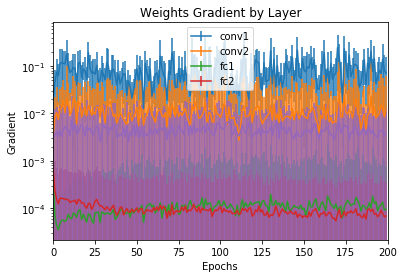

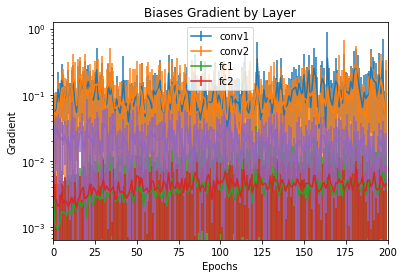

In [10]:
# Plotting gradients
n_layers = len(tf.trainable_variables()) // 2
x = np.arange(epochs)
i = 0
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()
i = 1
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()

In [11]:
def confusion_matrix(targets, outputs):
    '''Returns a confusion matrix. Both targets and outputs
    should be 1-D arrays of zeros and ones.'''
    encoded_data = 2*targets+outputs  # Map targets and outputs to {0, 1, 2, 3}
    TN = np.sum(encoded_data == 0)  # True negatives
    FP = np.sum(encoded_data == 1)  # False positives
    FN = np.sum(encoded_data == 2)  # False negatives
    TP = np.sum(encoded_data == 3)  # True positives
    return ((TP, FP), (FN, TN))

def roc_curve(targets, outputs):
    '''Returns a ROC curve. Outputs should be in range 0-1
    in order to move the threshold.'''
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        outputs_with_threshold = (outputs > threshold).astype(np.float)
        ((TP, FP), (FN, TN)) = confusion_matrix(
            targets, 
            outputs_with_threshold)
        tpr.append(TP/(TP+FN))
        fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)

accs = sess.run(accuracy,
             feed_dict={
            model_input: cifar10.training_data,
                       target: cifar10.training_labels,
            keep_prob: 1.0
        })

accs = np.asarray(accs)
[[VN,FP],[FN,VP]] = confusion_matrix(
    accs,
    (accs>0.5).astype(np.float))
print('VP: %d, VN: %d, FP: %d, FN: %d' %(VP,VN,FP,FN))
print('Porcentaje de clasificaciones correctas: %%%f' %(100.0*(VP+VN)/(VP+VN+FP+FN)))
print('Precision: %%%f' %(100.0*VP/(VP+FP)))
print('Recall: %%%f' %(100.0*VP/(VP+FN)))
print('')


AttributeError: 'CIFAR10' object has no attribute 'training_data'